In [3]:
import pandas as pd
from Main import settings, features, pf_set
import time
import pickle
from pandas.tseries.offsets import DateOffset
import Prepare_Data
import data_run_files
import return_prediction_functions
from return_prediction_functions import rff
import numpy as np
from pandas.tseries.offsets import MonthEnd
from sklearn.linear_model import Ridge
import General_Functions
import pickle
import Estimate_Covariance_Matrix
import os
import prepare_portfolio_data
import portfolio_choice_functions
import scipy.linalg
import functools
from scipy.optimize import minimize
import datetime
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


folder_name = "much_more_data"
output_path = os.path.join(folder_name, "")  


file_path_cluster_labels = "Data/Cluster Labels.csv"
file_path_factor_details = "Data/Factor Details.xlsx"



In [2]:

file_path_usa_dsf = os.path.join(".", folder_name, "usa_dsf.parquet")
file_path_usa = os.path.join(".", folder_name, "usa_rvol.parquet")
file_path_id_test = os.path.join(".", folder_name, "top_5_percent_ids.csv")
file_path_market_returns = os.path.join(".", folder_name, "market_returns_test.csv")
output_path_usa_dsf = os.path.join(".", folder_name, "usa_dsf_test.parquet")
output_path_usa = os.path.join(".", folder_name, "usa_test.parquet")
output_path_market_returns = os.path.join(folder_name, "market_returns_test.csv")
file_path_world_ret = os.path.join(".", folder_name, "world_ret_test.csv")
output_path = os.path.join(".", folder_name, "")  

file_path_usa_test = os.path.join(".", folder_name, "usa_test.parquet")
daily_file_path = os.path.join(".", folder_name, "usa_dsf_test.parquet")
risk_free_path = os.path.join(".", folder_name, "risk_free_test.csv")
market_path = os.path.join(".", folder_name, "market_returns_test.csv")

# Definér datoer
start_date = pd.to_datetime('1952-12-31')
end_date = pd.to_datetime('2022-12-31')

# Processering af risk_free med data_run_files
#risk_free = data_run_files.process_risk_free_rate(risk_free_path, start_date, output_path = risk_free_path)
risk_free = pd.read_csv(risk_free_path)
# Udregning af wealth
wealth_end = pf_set["wealth"]
end = settings["split"]["test_end"]
market_test = Prepare_Data.load_and_filter_market_returns_test(market_path)
wealth = Prepare_Data.wealth_func(wealth_end, end, market_test, risk_free)

h_list = [1]  # Horisonter

Filen er indlæst og filtreret succesfuldt.


In [45]:
# billede outputfolder
output_folder = folder_name


In [46]:
output_path_daily = os.path.join(".", folder_name, "daily.csv")
daily = pd.read_csv(output_path_daily, parse_dates=["date", "eom"])

input_path_chars_behandlet = os.path.join(".", folder_name, "chars_behandlet.parquet")
chars = pd.read_parquet(input_path_chars_behandlet)

In [5]:
def rff(X, p=None, g=None, W=None):
    """
    Genererer Random Fourier Features (RFF) fra input-data.

    Args:
        X (np.ndarray): Input-data som en matrix (n x d).
        p (int): Antal Fourier-funktioner (skal være delbart med 2).
        g (float): Varians/skala for vægtmatrixen W.
        W (np.ndarray, optional): Foruddefineret vægtmatrix (d x p/2). Hvis None, genereres tilfældige vægte.

    Returns:
        dict: En dictionary med:
            - "W": Vægtmatrixen (d x p/2).
            - "X_cos": Cosinus-transformeret data (n x p/2).
            - "X_sin": Sinus-transformeret data (n x p/2).

    Example:
        X = np.random.rand(100, 5)  # 100 eksempler, 5 features
        rff_result = rff(X, p=10, g=1.0)
        print("W:", rff_result["W"].shape)
        print("X_cos:", rff_result["X_cos"].shape)
        print("X_sin:", rff_result["X_sin"].shape)
    """

    # Tjek at p er delbart med 2
    if p % 2 != 0:
        raise ValueError("p skal være delbart med 2!")

    if W is None:
        k = X.shape[1]  # Antal features (dimensionen af X)
        W = np.random.multivariate_normal(
            mean=np.zeros(k),
            cov=g * np.eye(k),
            size=p // 2
        ).T  

    X_new = np.dot(X, W)  

    X_cos = np.cos(X_new)
    X_sin = np.sin(X_new)

    return {"W": W, "X_cos": X_cos, "X_sin": X_sin}

In [7]:
def rff_hp_search_new(data, feat, p_vec, g_vec, l_vec, seed):
    """
    Hyperparameter-tuning for Random Fourier Features + Ridge Regression.
    Korrekt de-meaning af både features og target. Manuel intercept-tilføjelse.

    Returns:
        dict: Model, predictions, hyperparametre, weights og optimale valg.
    """
    np.random.seed(seed)
    val_errors_list = []
    rff_info = {}

    for g in g_vec:
        rff_train = rff(data["train"][feat].values, p=max(p_vec), g=g)
        rff_val = rff(data["val"][feat].values, p=max(p_vec), W=rff_train["W"])

        for p in p_vec:
            half_p = int(p // 2)
            X_train = (p ** -0.5) * np.hstack((rff_train["X_cos"][:, :half_p], rff_train["X_sin"][:, :half_p]))
            X_val = (p ** -0.5) * np.hstack((rff_val["X_cos"][:, :half_p], rff_val["X_sin"][:, :half_p]))

            # De-mean features
            X_train_mean = X_train.mean(axis=0)
            X_train_demeaned = X_train - X_train_mean
            X_val_demeaned = X_val - X_train_mean

            # De-mean target
            y_train = data["train"]["ret_pred"].values
            y_val = data["val"]["ret_pred"].values
            y_train_mean = y_train.mean()
            y_train_demeaned = y_train - y_train_mean

            for lam in l_vec:
                model = Ridge(alpha=lam, fit_intercept=False)
                model.fit(X_train_demeaned, y_train_demeaned)

                preds_val = model.predict(X_val_demeaned) + y_train_mean #+ (-np.dot(X_train_mean, model.coef_)) #Her bliver det gjort for anden gang
                mse = np.mean((preds_val - y_val) ** 2)

                val_errors_list.append({"g": g, "p": p, "lambda": lam, "mse": mse})

        rff_info[str(g)] = rff_train["W"]

    # Saml hyperparametre
    val_errors_df = pd.DataFrame(val_errors_list)
    opt_idx = val_errors_df["mse"].idxmin()
    opt_hps = val_errors_df.loc[opt_idx]
    print(f"Optimal g: {opt_hps['g']}, p: {opt_hps['p']}, lambda: {opt_hps['lambda']}, MSE: {opt_hps['mse']}")

    # --- Re-fit på train_full ---
    opt_g = str(opt_hps["g"])
    opt_p = int(opt_hps["p"])
    half_opt_p = int(opt_p // 2)
    opt_W = rff_info[opt_g][:, :half_opt_p]

    rff_train_full = rff(data["train_full"][feat].values, p=opt_p, W=opt_W)
    X_train_full = (opt_p ** -0.5) * np.hstack((rff_train_full["X_cos"], rff_train_full["X_sin"]))
    X_train_full_mean = X_train_full.mean(axis=0)
    X_train_full_demeaned = X_train_full - X_train_full_mean

    y_train_full = data["train_full"]["ret_pred"].values
    y_train_full_mean = y_train_full.mean()
    y_train_full_demeaned = y_train_full - y_train_full_mean

    final_model = Ridge(alpha=opt_hps["lambda"], fit_intercept=False)
    final_model.fit(X_train_full_demeaned, y_train_full_demeaned)

    intercept_full = -np.dot(X_train_full_mean, final_model.coef_) + y_train_full_mean

    # --- Forudsig på test ---
    rff_test = rff(data["test"][feat].values, p=opt_p, W=opt_W)
    X_test = (opt_p ** -0.5) * np.hstack((rff_test["X_cos"], rff_test["X_sin"]))
    X_test_demeaned = X_test - X_train_full_mean

    preds_test = final_model.predict(X_test_demeaned) + intercept_full

    pred_op = data["test"][["id", "eom", "eom_pred_last"]].copy()
    pred_op["pred"] = preds_test

    return {
        "fit": final_model,
        "pred": pred_op,
        "hp_search": val_errors_df,
        "W": opt_W,
        "opt_hps": opt_hps
    }


In [9]:
def ridge_hp_search(data, feat, vol_scale, lambdas):
    """
    Søger efter den optimale lambda for Ridge Regression med de-meanede features og manuelt tilføjet intercept.

    Args:
        data (dict): Dictionary med train, val, test og train_full data.
        feat (list): Liste over feature-kolonner.
        vol_scale (bool): Om forudsigelser skal skaleres med volatilitet (rvol_m).
        lambdas (list): Liste over lambda-værdier til hyperparametertuning.

    Returns:
        dict: Dictionary med:
            - "fit": Den endelige Ridge-model.
            - "hp_search": DataFrame med resultater fra hyperparametertuning.
            - "l_opt": Optimal lambda.
            - "pred": Forudsigelser på testdata.
            - "pred_val": Forudsigelser på valideringsdata.
            - "feat_imp": Feature-importance fra modellen.
    """

    # Træning og valideringsdata
    X_train = data["train"][feat].values
    y_train = data["train"]["ret_pred"].values
    X_val = data["val"][feat].values
    y_val = data["val"]["ret_pred"].values

    # De-mean features (vigtigt når fit_intercept=False)
    X_train_mean = X_train.mean(axis=0)
    X_train -= X_train_mean
    X_val -= X_train_mean  # Brug træningsmiddel for validering

    # Ridge regression hyperparametertuning
    val_errors = []
    for l in lambdas:
        ridge = Ridge(alpha=l, fit_intercept=False)
        ridge.fit(X_train, y_train)
        y_pred_val = ridge.predict(X_val)
        mse = mean_squared_error(y_val, y_pred_val)
        val_errors.append({"lambda": l, "mse": mse})

    # Konverter resultater til DataFrame
    lambda_search = pd.DataFrame(val_errors)

    # Plot fejl vs lambda
    plt.figure(figsize=(8, 6))
    plt.plot(np.log10(lambda_search["lambda"]), lambda_search["mse"], marker="o")
    plt.xlabel("log10(lambda)")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title("Ridge Regression Hyperparameter Tuning")
    plt.grid(True)
    plt.show()

    # Find optimal lambda
    opt_lambda = lambda_search.loc[lambda_search["mse"].idxmin(), "lambda"]

    # Fit model på træning
    ridge_opt = Ridge(alpha=opt_lambda, fit_intercept=False)
    ridge_opt.fit(X_train, y_train)
    intercept = -np.dot(X_train_mean, ridge_opt.coef_)  # Beregn intercept

    # Valideringsforudsigelser med intercept
    pred_val_op = data["val"][["id", "eom", "eom_pred_last"]].copy()
    pred_val_op["pred"] = ridge_opt.predict(X_val) + intercept

    # Re-fit på train_full
    X_train_full = data["train_full"][feat].values
    y_train_full = data["train_full"]["ret_pred"].values
    X_train_full_mean = X_train_full.mean(axis=0)
    X_train_full -= X_train_full_mean

    ridge_opt.fit(X_train_full, y_train_full)
    intercept_full = -np.dot(X_train_full_mean, ridge_opt.coef_) 

    # Forudsig på test
    X_test = data["test"][feat].values
    X_test -= X_train_full_mean
    pred_op = data["test"][["id", "eom", "eom_pred_last"]].copy()
    pred_op["pred"] = ridge_opt.predict(X_test) + intercept_full

    # Feature-importance
    feat_imp = pd.DataFrame({
        "feature": feat,
        "importance": np.abs(ridge_opt.coef_)
    }).sort_values(by="importance", ascending=False)

    if vol_scale:
        pred_val_op["pred_vol"] = pred_val_op["pred"]
        pred_op["pred_vol"] = pred_op["pred"]
        pred_val_op["pred"] *= data["val"]["rvol_m"].values
        pred_op["pred"] *= data["test"]["rvol_m"].values

    # Returnér resultater
    return {
        "fit": ridge_opt,
        "hp_search": lambda_search,
        "l_opt": opt_lambda,
        "pred": pred_op,
        "pred_val": pred_val_op,
        "feat_imp": feat_imp
    }


In [48]:
output_data_ret_ld1_csv = os.path.join(".", folder_name, "data_ret_ld1.csv")
data_ret_ld1 = pd.read_csv(output_data_ret_ld1_csv)

## lav gennemsnit for hver måned i ret_ld1

In [54]:
mean_ret_ld1_per_eom = data_ret_ld1.groupby("eom")["ret_ld1"].mean().reset_index()
mean_ret_ld1_per_eom.rename(columns={"ret_ld1": "mean_ret_ld1"}, inplace=True)

mean_ret_ld1_per_eom["ret_ld1"] =data_ret_ld1["ret_ld1"]

In [ ]:


# Forbered data
df = mean_ret_ld1_per_eom.copy()
df["eom"] = pd.to_datetime(df["eom"])
df = df.set_index("eom").sort_index()

start_date = pd.to_datetime("2010-12-31")

# === ARIMA ===
train_initial = df.loc[:start_date, "ret_ld1"]
order_selection = arma_order_select_ic(train_initial, ic='aic', max_ar=3, max_ma=3)
best_order = order_selection['aic_min_order']
print(f"Valgt ARIMA(p,d,q): ({best_order[0]}, 0, {best_order[1]})")

arima_results = []
for current_date in df.loc[start_date:].index:
    train_data = df.loc[:current_date - pd.offsets.MonthEnd(1), "ret_ld1"]
    try:
        model = ARIMA(train_data, order=(best_order[0], 0, best_order[1]))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1)[0]
    except:
        forecast = None
    arima_results.append({"eom": current_date, "arima_pred": forecast})

arima_df = pd.DataFrame(arima_results).set_index("eom")

# === Naiv model ===
df["naive_pred"] = df["ret_ld1"].shift(1)

# === EWMA ===
df["ewma_pred"] = df["ret_ld1"].ewm(span=6, adjust=False).mean().shift(1)

# === OLS model ===
df["lag1"] = df["ret_ld1"].shift(1)
df["lag2"] = df["ret_ld1"].shift(2)
df["lag3"] = df["ret_ld1"].shift(3)

train = df.loc[:start_date - pd.offsets.MonthEnd(1)].dropna()
test = df.loc[start_date:].dropna()

X_train = train[["lag1", "lag2", "lag3"]]
y_train = train["ret_ld1"]
X_test = test[["lag1", "lag2", "lag3"]]

ols_model = LinearRegression().fit(X_train, y_train)
test["ols_pred"] = ols_model.predict(X_test)

# === Merge alt sammen ===
df = df.join(arima_df)

# === Evalueringsdata ===
eval_df = df.loc[start_date:].dropna()

from sklearn.metrics import r2_score

def r2_oos_mean(df, actual_col, pred_col):
    df_clean = df[[actual_col, pred_col]].dropna()
    rss = ((df_clean[actual_col] - df_clean[pred_col]) ** 2).mean()
    tss = (df_clean[actual_col] ** 2).mean()
    return 1 - rss / tss if tss != 0 else np.nan

r2_scores = {
    "ARIMA": r2_oos_mean(eval_df, "ret_ld1", "arima_pred"),
    "Naiv": r2_oos_mean(eval_df, "ret_ld1", "naive_pred"),
    "EWMA (span=6)": r2_oos_mean(eval_df, "ret_ld1", "ewma_pred"),
    "OLS (lag1-3)": r2_oos_mean(test, "ret_ld1", "ols_pred")
}

print("\nR² fra 2010 og frem:")
for model, score in r2_scores.items():
    print(f"{model}: {score:.6f}")

plt.figure(figsize=(14, 6))
plt.plot(eval_df.index, eval_df["ret_ld1"], label="Faktisk mean ret_ld1", color='black')
plt.plot(eval_df.index, eval_df["arima_pred"], label="ARIMA", linestyle="--")
plt.plot(eval_df.index, eval_df["naive_pred"], label="Naiv", linestyle="--")
plt.plot(eval_df.index, eval_df["ewma_pred"], label="EWMA (span=6)", linestyle="--")
plt.plot(test.index, test["ols_pred"], label="OLS (lag1-3)", linestyle="--")
plt.axvline(start_date, color='grey', linestyle=':', label="Forecast start")
plt.title("Sammenligning af modeller på mean ret_ld1")
plt.xlabel("Dato")
plt.ylabel("Afkast")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [92]:
eval_df["arima_pred"]

eom
2010-12-31    0.019404
2011-01-31    0.007463
2011-02-28    0.018155
2011-03-31    0.007936
2011-04-30    0.014132
                ...   
2022-07-31    0.027167
2022-08-31   -0.000947
2022-09-30    0.009088
2022-10-31    0.021598
2022-11-30    0.008292
Name: arima_pred, Length: 144, dtype: float64

In [97]:
chars_arima
chars_arima = chars_arima[chars_arima["valid"] == True]

In [98]:
chars_arima[["id", "eom", "pred_ld1", "ret_ld1"]]

,id,eom,pred_ld1,ret_ld1
0,10032,2000-01-31,NaN,0.210087
1,10032,2000-02-29,NaN,0.175479
2,10032,2000-03-31,NaN,0.145499
3,10032,2000-04-30,NaN,0.084941
4,10032,2000-05-31,NaN,0.349549
...,...,...,...,...
260989,92655,2022-07-31,-0.003563,-0.044328
260990,92655,2022-08-31,-0.004355,-0.026268
260991,92655,2022-09-30,-0.003312,0.096893
260992,92655,2022-10-31,-0.003034,-0.016168


In [11]:
h = 1
col_name = "ret_ld" + str(h)
pred_y_values = data_ret_ld1[col_name] 

# Brug 'id' og 'eom' fra data_ret_ld1
pred_y_df = data_ret_ld1[['id', 'eom']].copy()
pred_y_df['eom_pred_last'] = data_ret_ld1['eom_ret']   
pred_y_df['ret_pred'] = pred_y_values

monthly_avg = pred_y_df.groupby('eom')['ret_pred'].mean().rename('monthly_avg').reset_index()

monthly_avg['rolling_avg'] = monthly_avg['monthly_avg'].shift(1).rolling(window=12, min_periods=1).mean()

pred_y_df = pred_y_df.merge(monthly_avg, on='eom', how='left')

In [12]:

monthly_avg['eom'] = pd.to_datetime(monthly_avg['eom'])
monthly_avg.set_index('eom', inplace=True)

if 'rolling_avg' in monthly_avg.columns:
    monthly_avg = monthly_avg.drop(columns=['rolling_avg'])

series_to_model = monthly_avg['monthly_avg']

val_end = "2010-12-31"
history_series = series_to_model.loc[:val_end].copy()
test_series = series_to_model.loc[val_end:]

predictions = []

for date in test_series.index:
    print(f"Træner model op til: {date}")

    model = pm.auto_arima(
        history_series,
        seasonal=False,
        stepwise=True,
        suppress_warnings=True,
        error_action='ignore'
    )
    
    forecast = model.predict(n_periods=1)[0]
    predictions.append(forecast)
    
    history_series.loc[date] = test_series.loc[date]

forecast_test_series = pd.Series(predictions, index=test_series.index)

plt.figure(figsize=(12,6))
plt.plot(series_to_model, label='Faktiske data')
plt.plot(forecast_test_series, label='Rolling Forecast (med Re-Fit)', linestyle='--')
plt.legend()
plt.title('Rolling Forecast med Monthly Re-Fit (Testperiode)')
plt.show()

demeaned_test = test_series - forecast_test_series

plt.figure(figsize=(10,5))
plt.plot(demeaned_test, label='Demeaned Test Returns')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend()
plt.title('Demeaned Returns (Testperiode med Re-Fit)')
plt.show()


Træner model op til: 2010-12-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2011-01-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2011-02-28 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2011-03-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2011-04-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2011-05-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2011-06-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2011-07-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2011-08-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2011-09-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2011-10-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2011-11-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2011-12-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2012-01-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2012-02-29 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2012-03-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2012-04-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2012-05-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2012-06-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2012-07-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2012-08-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2012-09-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2012-10-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2012-11-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2012-12-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2013-01-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2013-02-28 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2013-03-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2013-04-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2013-05-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2013-06-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2013-07-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2013-08-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2013-09-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2013-10-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2013-11-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2013-12-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2014-01-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2014-02-28 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2014-03-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2014-04-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2014-05-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2014-06-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2014-07-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2014-08-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2014-09-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2014-10-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2014-11-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2014-12-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2015-01-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2015-02-28 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2015-03-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2015-04-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2015-05-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2015-06-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2015-07-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2015-08-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2015-09-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2015-10-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2015-11-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2015-12-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2016-01-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2016-02-29 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2016-03-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2016-04-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2016-05-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2016-06-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2016-07-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2016-08-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2016-09-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2016-10-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2016-11-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2016-12-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2017-01-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2017-02-28 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2017-03-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2017-04-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2017-05-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2017-06-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2017-07-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2017-08-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2017-09-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2017-10-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2017-11-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2017-12-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2018-01-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2018-02-28 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2018-03-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2018-04-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2018-05-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2018-06-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2018-07-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2018-08-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2018-09-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2018-10-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2018-11-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2018-12-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2019-01-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2019-02-28 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2019-03-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2019-04-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2019-05-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2019-06-30 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2019-07-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

Træner model op til: 2019-08-31 00:00:00


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Us

KeyboardInterrupt: 

In [14]:
print(monthly_avg.head())
print(monthly_avg.dtypes)


            monthly_avg
eom                    
1952-12-31     0.008364
1953-01-31     0.005873
1953-02-28    -0.011935
1953-03-31    -0.019808
1953-04-30     0.001024
monthly_avg    float64
dtype: object


## Mest simple model uden demean

In [133]:
## Mest simple model uden demean

start_time = time.time()
models = []

# --- 1. Forbered target (ret_pred) ---
h = 1
col_name = "ret_ld" + str(h)
pred_y_values = data_ret_ld1[col_name] 

# Korrekt: Brug id og eom fra data_ret_ld1
pred_y_df = data_ret_ld1[['id', 'eom']].copy()
pred_y_df['eom_pred_last'] = data_ret_ld1['eom_ret'] 
pred_y_df['ret_pred'] = pred_y_values

# Merge med valid features fra chars
valid_chars = chars[chars['valid'] == True]
data_pred = pd.merge(pred_y_df, valid_chars, on=['id', 'eom'], how='inner')

# --- 2. Definér yearly model update ---
update_freq = "yearly"
val_ends = pd.date_range(start=settings['split']['train_end'],
                         end=settings['split']['test_end'],
                         freq='YE').to_pydatetime().tolist()
test_inc = 1

# --- 3. Loop over valideringsdatoer og træn model ---
op = {}
inner_start = time.time()

for val_end in val_ends:
    train_test_val = return_prediction_functions.data_split(
        data_pred,
        type=update_freq,
        val_end=val_end,
        val_years=settings['split']['val_years'],
        train_start=settings['screens']['start'],
        train_lookback=settings['split']['train_lookback'],
        retrain_lookback=settings['split']['retrain_lookback'],
        test_inc=test_inc,
        test_end=settings['split']['test_end']
    )

    if train_test_val["test"].empty:
        print(f"Test datasættet er tomt for valideringsperiode: {val_end}. Stopper forudsigelser.")
        break

    model_op = rff_hp_search_new(
        train_test_val,
        feat=features,
        p_vec=settings['rff']['p_vec'],
        g_vec=settings['rff']['g_vec'],
        l_vec=settings['rff']['l_vec'],
        seed=settings['seed_no']
    )

    op[val_end] = model_op

inner_time = time.time() - inner_start
print("Total time for current horizon:", inner_time, "seconds")

# --- 4. Gem model ---
model_filename = f"{output_path}/model_{h}_new_rff.pkl"
with open(model_filename, "wb") as f:
    pickle.dump(op, f)

models.append(op)

# --- 5. Total tid ---
total_time = time.time() - start_time
print("Total run time:", total_time, "seconds")

ValueError: You are trying to merge on object and datetime64[ns] columns for key 'eom'. If you wish to proceed you should use pd.concat

# Demean preds

In [17]:
import pandas as pd
import time
import pickle

# --- Start tid ---
start_time = time.time()
models = []

h = 1
col_name = "ret_ld" + str(h)
pred_y_values = data_ret_ld1[col_name] 

pred_y_df = data_ret_ld1[['id', 'eom']].copy()
pred_y_df['eom_pred_last'] = data_ret_ld1['eom_ret'] 
pred_y_df['ret_pred'] = pred_y_values

pred_y_df['eom'] = pd.to_datetime(pred_y_df['eom'])
pred_y_df['eom_pred_last'] = pd.to_datetime(pred_y_df['eom_pred_last'])

valid_chars = chars[chars['valid'] == True].copy()
valid_chars['eom'] = pd.to_datetime(valid_chars['eom'])

data_pred = pd.merge(pred_y_df, valid_chars, on=['id', 'eom'], how='inner')

forecast_df = monthly_avg_with_forecast.reset_index()  
forecast_df.columns = ['eom', 'pred_mon_ld1']  

forecast_df['eom'] = pd.to_datetime(forecast_df['eom'])

data_pred = data_pred.merge(forecast_df, on='eom', how='left')

data_pred["ret_pred"] = data_pred["ret_pred"] - data_pred["pred_mon_ld1"]

update_freq = "yearly"
val_ends = pd.date_range(start=settings['split']['train_end'],
                         end=settings['split']['test_end'],
                         freq='YE').to_pydatetime().tolist()
test_inc = 1

op = {}
inner_start = time.time()

for val_end in val_ends:
    train_test_val = return_prediction_functions.data_split(
        data_pred,
        type=update_freq,
        val_end=val_end,
        val_years=settings['split']['val_years'],
        train_start=settings['screens']['start'],
        train_lookback=settings['split']['train_lookback'],
        retrain_lookback=settings['split']['retrain_lookback'],
        test_inc=test_inc,
        test_end=settings['split']['test_end']
    )

    if train_test_val["test"].empty:
        print(f"Test datasættet er tomt for valideringsperiode: {val_end}. Stopper forudsigelser.")
        break

    model_op = return_prediction_functions.rff_hp_search(
        train_test_val,
        feat=features,
        p_vec=settings['rff']['p_vec'],
        g_vec=settings['rff']['g_vec'],
        l_vec=settings['rff']['l_vec'],
        seed=settings['seed_no']
    )

    op[val_end] = model_op

inner_time = time.time() - inner_start
print("Total time for current horizon:", inner_time, "seconds")

model_filename = f"{output_path}/model_{h}_arima_pred.pkl"
with open(model_filename, "wb") as f:
    pickle.dump(op, f)

models.append(op)

total_time = time.time() - start_time
print("Total run time:", total_time, "seconds")


g: 0.04978706836786394
  --> p: 2
  --> p: 4
  --> p: 8
  --> p: 16
  --> p: 32
  --> p: 64
  --> p: 128
  --> p: 256
  --> p: 512
g: 0.13533528323661267
  --> p: 2
  --> p: 4
  --> p: 8
  --> p: 16
  --> p: 32
  --> p: 64
  --> p: 128
  --> p: 256
  --> p: 512
Optimal g: 0.04978706836786394, p: 512.0, lambda: 15.291127026637097, MSE: 0.009434716614757725
g: 0.04978706836786394
  --> p: 2
  --> p: 4
  --> p: 8
  --> p: 16
  --> p: 32
  --> p: 64
  --> p: 128
  --> p: 256
  --> p: 512
g: 0.13533528323661267
  --> p: 2
  --> p: 4
  --> p: 8
  --> p: 16
  --> p: 32
  --> p: 64
  --> p: 128
  --> p: 256
  --> p: 512
Optimal g: 0.04978706836786394, p: 512.0, lambda: 10.208618589139931, MSE: 0.010391804890036535
g: 0.04978706836786394
  --> p: 2
  --> p: 4
  --> p: 8
  --> p: 16
  --> p: 32
  --> p: 64
  --> p: 128
  --> p: 256
  --> p: 512
g: 0.13533528323661267
  --> p: 2
  --> p: 4
  --> p: 8
  --> p: 16
  --> p: 32
  --> p: 64
  --> p: 128
  --> p: 256
  --> p: 512
Optimal g: 0.049787068

# new

In [ ]:
# --- Start tid ---
start_time = time.time()
models = []

# --- 1. Forbered target (ret_pred) ---
h = 1
col_name = "ret_ld" + str(h)
pred_y_values = data_ret_ld1[col_name] 

pred_y_df = data_ret_ld1[['id', 'eom']].copy()
pred_y_df['eom_pred_last'] = data_ret_ld1['eom_ret'] 
pred_y_df['ret_pred'] = pred_y_values

pred_y_df['eom'] = pd.to_datetime(pred_y_df['eom'])
pred_y_df['eom_pred_last'] = pd.to_datetime(pred_y_df['eom_pred_last'])

valid_chars = chars[chars['valid'] == True].copy()
valid_chars['eom'] = pd.to_datetime(valid_chars['eom'])

data_pred = pd.merge(pred_y_df, valid_chars, on=['id', 'eom'], how='inner')

forecast_df = data_pred.groupby('eom')["ret_pred"].mean().reset_index()
forecast_df.columns = ['eom', 'pred_mon_ld1']

data_pred = data_pred.merge(forecast_df, on='eom', how='left')

data_pred["ret_pred"] = data_pred["ret_pred"] - data_pred["pred_mon_ld1"]

update_freq = "yearly"
val_ends = pd.date_range(start=settings['split']['train_end'],
                         end=settings['split']['test_end'],
                         freq='YE').to_pydatetime().tolist()
test_inc = 1

op = {}
test_predictions_all = []
train_predictions_all = []
val_hp_search_all = []

inner_start = time.time()

for val_end in val_ends:
    train_test_val = return_prediction_functions.data_split(
        data_pred,
        type=update_freq,
        val_end=val_end,
        val_years=settings['split']['val_years'],
        train_start=settings['screens']['start'],
        train_lookback=settings['split']['train_lookback'],
        retrain_lookback=settings['split']['retrain_lookback'],
        test_inc=test_inc,
        test_end=settings['split']['test_end']
    )

    if train_test_val["test"].empty:
        print(f"Test datasættet er tomt for valideringsperiode: {val_end}. Stopper forudsigelser.")
        break

    model_op = return_prediction_functions.rff_hp_search(
        train_test_val,
        feat=features,
        p_vec=settings['rff']['p_vec'],
        g_vec=settings['rff']['g_vec'],
        l_vec=settings['rff']['l_vec'],
        seed=settings['seed_no']
    )

    test_preds_df = model_op["pred"].copy()
    test_preds_df["val_end"] = val_end
    test_predictions_all.append(test_preds_df)

    train_preds_df = model_op["train_pred"].copy()
    train_preds_df["val_end"] = val_end
    train_predictions_all.append(train_preds_df)

    hp_search_df = model_op["hp_search"].copy()
    hp_search_df["val_end"] = val_end
    val_hp_search_all.append(hp_search_df)

    op[val_end] = model_op

inner_time = time.time() - inner_start
print("Total time for current horizon:", inner_time, "seconds")

model_filename = f"{output_path}/model_{h}_demean_pred.pkl"
with open(model_filename, "wb") as f:
    pickle.dump(op, f)
models.append(op)

test_pred_df = pd.concat(test_predictions_all, ignore_index=True)
train_pred_df = pd.concat(train_predictions_all, ignore_index=True)
val_hp_df = pd.concat(val_hp_search_all, ignore_index=True)

test_pred_df.to_csv(f"{output_path}/test_predictions_h{h}.csv", index=False)
train_pred_df.to_csv(f"{output_path}/train_predictions_h{h}.csv", index=False)
val_hp_df.to_csv(f"{output_path}/val_hp_search_h{h}.csv", index=False)

# --- 5. Total tid ---
total_time = time.time() - start_time
print("Total run time:", total_time, "seconds")


In [67]:
chars_normal = prepare_portfolio_data.add_return_predictions(chars,settings, output_path)

In [13]:
def add_return_predictions_demean(chars, settings, get_from_path_model):

    for h in range(1, 2): #Hardcoded 2 ind for vi har kun 1 horizon
        file_path = os.path.join(get_from_path_model, f"model_1_demean_standarliseret_pred_seed1.pkl")
        with open(file_path, 'rb') as f:
            model_dict = pickle.load(f)

        all_preds = []
        for date_key, subdict in model_dict.items():
            # Antag at hver subdictionary indeholder en key "pred"
            pred_df = pd.DataFrame(subdict['pred'])
            all_preds.append(pred_df)

        # Saml alle forudsigelsesdata
        pred_df_all = pd.concat(all_preds, ignore_index=True)
        print(pred_df_all)
        pred_df_all = pred_df_all[['id', 'eom', 'pred']].rename(columns={'pred': f'pred_ld{h}'})
        print(pred_df_all[pred_df_all['pred_ld1'].isna()])

        # Merge forudsigelserne ind i chars
        chars = chars[chars["valid"] == True]
        chars = chars.merge(pred_df_all, on=['id', 'eom'], how='left')

    return chars

In [23]:
chars_demean_new = add_return_predictions_demean(chars,settings, output_path)

C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.5.2 when using version 1.6.1. This might lead to breaking code o

           id        eom eom_pred_last      pred
0       10032 2000-12-31    2001-01-31  0.001332
1       10032 2001-01-31    2001-02-28  0.002947
2       10032 2001-02-28    2001-03-31 -0.000276
3       10032 2001-03-31    2001-04-30  0.002108
4       10032 2001-04-30    2001-05-31  0.000357
...       ...        ...           ...       ...
181854  92655 2022-07-31    2022-08-31 -0.001784
181855  92655 2022-08-31    2022-09-30  0.000021
181856  92655 2022-09-30    2022-10-31 -0.002243
181857  92655 2022-10-31    2022-11-30 -0.000038
181858  92655 2022-11-30    2022-12-31  0.000006

[181859 rows x 4 columns]
Empty DataFrame
Columns: [id, eom, pred_ld1]
Index: []


In [34]:
chars_demean_new = add_return_predictions_demean(chars,settings, output_path)
chars_demean_new = chars_demean_new[chars_demean_new["valid"] == True]
chars_demean_new = chars_demean_new[["id", "eom", "pred_ld1", "ret_ld1"]].dropna()
chars_demean_new.shape

C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.5.2 when using version 1.6.1. This might lead to breaking code o

           id        eom eom_pred_last      pred
0       10032 2000-12-31    2001-01-31  0.001332
1       10032 2001-01-31    2001-02-28  0.002947
2       10032 2001-02-28    2001-03-31 -0.000276
3       10032 2001-03-31    2001-04-30  0.002108
4       10032 2001-04-30    2001-05-31  0.000357
...       ...        ...           ...       ...
181854  92655 2022-07-31    2022-08-31 -0.001784
181855  92655 2022-08-31    2022-09-30  0.000021
181856  92655 2022-09-30    2022-10-31 -0.002243
181857  92655 2022-10-31    2022-11-30 -0.000038
181858  92655 2022-11-30    2022-12-31  0.000006

[181859 rows x 4 columns]
Empty DataFrame
Columns: [id, eom, pred_ld1]
Index: []


(181859, 4)

In [35]:
from sklearn.metrics import mean_squared_error

valgt_dato = "2000-12-31"
slut_dato = "2010-12-31"

chars_demean_new_test = chars_demean_new[
    (chars_demean_new["eom"] > valgt_dato) & (chars_demean_new["eom"] <= slut_dato)
]

mse = mean_squared_error(chars_demean_new_test["ret_ld1"], chars_demean_new_test["pred_ld1"])
print("Gennemsnitlig MSE:", mse)


Gennemsnitlig MSE: 0.011506810272738947


In [60]:
def r2_oos_mean(df, actual_col="ret_ld1", pred_col="pred_ld1"):
    """
    Korrekt out-of-sample R² baseret på MSE og varians omkring middelværdi.

    Args:
        df (pd.DataFrame): DataFrame med faktisk og forudsagt afkast.
        actual_col (str): Kolonnenavn for faktisk afkast.
        pred_col (str): Kolonnenavn for forudsagt afkast.

    Returns:
        float: Out-of-sample R².
    """
    df_clean = df[[actual_col, pred_col]].dropna()
    y = df_clean[actual_col]
    y_hat = df_clean[pred_col]

    rss = ((y - y_hat) ** 2).mean()
    tss = ((y - y.mean()) ** 2).mean()

    if tss == 0:
        return np.nan

    return 1 - rss / tss


In [193]:
import warnings
warnings.filterwarnings('ignore')
chars_normal = prepare_portfolio_data.add_return_predictions(chars,settings, output_path)
chars_normal = chars_normal[chars_normal["valid"] == True]
chars_arima = add_return_predictions_arima(chars, settings, output_path)
chars_demean_new = chars_demean_new[chars_demean_new["valid"] == True]

def r2_oos_mean(df, actual_col="ret_ld1", pred_col="pred_ld1"):
    """
    Beregner out-of-sample R² baseret på mean squared error og total variance.

    Args:
        df (pd.DataFrame): DataFrame med faktisk og forudsagt afkast.
        actual_col (str): Kolonnenavn for faktisk afkast.
        pred_col (str): Kolonnenavn for forudsagt afkast.

    Returns:
        float: Out-of-sample R².
    """
    df_clean = df[[actual_col, pred_col]].dropna()
    print(df_clean.shape)

    rss = ((df_clean[actual_col] - df_clean[pred_col]) ** 2).mean()
    tss = (df_clean[actual_col] ** 2).mean()

    if tss == 0:
        return np.nan

    return 1 - rss / tss




valgt_dato = "2011-01-01"

# Filtrer hele DataFrame baseret på 'eom'-kolonnen
chars_demean_new["pred_ld1"] = chars_demean_new["pred_ld1"]+optimal_q
chars_normal_test = chars_normal[chars_normal["eom"] > valgt_dato]
chars_arima_test = chars_arima[chars_arima["eom"] > valgt_dato]
chars_demean_new_test = chars_demean_new[chars_demean_new["eom"] > valgt_dato]
#chars_arima_with_mean_test = chars_arima_with_mean[chars_arima_with_mean["eom"] > valgt_dato]

chars_normal_r2 = r2_oos_mean(df = chars_normal_test)
chars_arima_r2 = r2_oos_mean(df = chars_arima_test)
chars_demean_new_r2 = r2_oos_mean(df = chars_demean_new_test)
#chars_arima_with_mean_r2 = r2_oos(df = chars_arima_with_mean_test)
print("chars_normal_r2 udgangspunkt", chars_normal_r2)
print("chars_arima_r2 uden add af mean", chars_arima_r2)
print("chars_demean_new_test_r2", chars_demean_new_r2)
#print("chars_arima_with_mean_r2", chars_arima_with_mean_r2)


           id        eom eom_pred_last      pred
0       10032 2000-12-31    2001-01-31  0.007833
1       10032 2001-01-31    2001-02-28 -0.009944
2       10032 2001-02-28    2001-03-31 -0.015594
3       10032 2001-03-31    2001-04-30 -0.012252
4       10032 2001-04-30    2001-05-31 -0.006963
...       ...        ...           ...       ...
181854  92655 2022-07-31    2022-08-31 -0.003563
181855  92655 2022-08-31    2022-09-30 -0.004355
181856  92655 2022-09-30    2022-10-31 -0.003312
181857  92655 2022-10-31    2022-11-30 -0.003034
181858  92655 2022-11-30    2022-12-31 -0.002103

[181859 rows x 4 columns]
Empty DataFrame
Columns: [id, eom, pred_ld1]
Index: []
(101378, 2)
(101378, 2)
(101378, 2)
chars_normal_r2 udgangspunkt 0.011852765157338463
chars_arima_r2 uden add af mean -0.006610226103258343
chars_demean_new_test_r2 0.006630377265665732


In [194]:
optimal_q

0.0034065572172519154

In [37]:
def mse_objective(q):
    df_temp = chars_demean_new.copy()
    df_temp["pred_ld1"] = df_temp["pred_ld1"] + q
    return mean_squared_error(df_temp["ret_ld1"], df_temp["pred_ld1"])

mse_result = minimize_scalar(mse_objective, bounds=(-5, 5), method='bounded')
print(f"Optimal q for MSE: {mse_result.x:.6f}")


Optimal q for MSE: 0.009911


In [236]:
from scipy.optimize import minimize_scalar

def optimize_q_r2(df, start_dato, slut_dato):
    """
    Finder optimal konstant q, der maksimerer R²_oos mellem start og slutdato.
    
    Args:
        df (pd.DataFrame): DataFrame med kolonner 'eom', 'ret_ld1', 'pred_ld1'
        start_dato (str): Startdato i format 'YYYY-MM-DD'
        slut_dato (str): Slutdato i format 'YYYY-MM-DD'
    
    Returns:
        tuple: (optimal_q, maksimeret R²)
    """
    df = df.copy()
    df["eom"] = pd.to_datetime(df["eom"])

    # Filtrér på dato
    df_period = df[(df["eom"] >= start_dato) & (df["eom"] <= slut_dato)]

    def objective(q):
        df_temp = df_period.copy()
        df_temp["pred_ld1"] = df_temp["pred_ld1"] + q
        r2 = r2_oos(df=df_temp)
        return -r2

    result = minimize_scalar(objective, bounds=(-5, 5), method='bounded')

    optimal_q = result.x
    max_r2 = -result.fun

    print(f"Optimal faktor q: {optimal_q:.6f}")
    print(f"Maksimeret R²: {max_r2:.6f}")

    return optimal_q, max_r2


In [23]:
chars_demean_new = chars_demean_new[chars_demean_new["valid"] == True]

In [24]:
from scipy.optimize import minimize_scalar
import pandas as pd
from datetime import datetime, timedelta

def optimize_q_r2(df, start_dato, slut_dato):
    df = df.copy()
    df["eom"] = pd.to_datetime(df["eom"])
    df_period = df[(df["eom"] >= start_dato) & (df["eom"] <= slut_dato)]

    def objective(q):
        df_temp = df_period.copy()
        df_temp["pred_ld1"] = df_temp["pred_ld1"] + q
        r2 = r2_oos(df=df_temp)
        return -r2

    result = minimize_scalar(objective, bounds=(-5, 5), method='bounded')
    optimal_q = result.x
    max_r2 = -result.fun
    return optimal_q, max_r2

def rullende_optimering_dato(df, første_slutdato, sidste_slutdato):
    resultater = []
    
    # Konverter til datetime
    slutdato = pd.to_datetime(første_slutdato)
    slut_slutdato = pd.to_datetime(sidste_slutdato)

    while slutdato <= slut_slutdato:
        startdato = slutdato - pd.DateOffset(years=10)

        try:
            optimal_q, max_r2 = optimize_q_r2(df, startdato, slutdato)
            resultater.append({
                "start": startdato.strftime("%Y-%m-%d"),
                "slut": slutdato.strftime("%Y-%m-%d"),
                "optimal_q": optimal_q,
                "R2_oos": max_r2
            })
        except Exception as e:
            print(f"Fejl for perioden {startdato} til {slutdato}: {e}")
            resultater.append({
                "start": startdato.strftime("%Y-%m-%d"),
                "slut": slutdato.strftime("%Y-%m-%d"),
                "optimal_q": None,
                "R2_oos": None
            })

        # Gå ét år frem
        slutdato += pd.DateOffset(years=1)

    return pd.DataFrame(resultater)


In [25]:
resultat_df = rullende_optimering_dato(df=chars_demean_new, 
                                       første_slutdato="2000-12-31", 
                                       sidste_slutdato="2022-12-31")


In [26]:
resultat_df

,start,slut,optimal_q,R2_oos
0,1990-12-31,2000-12-31,0.032062,0.964917
1,1991-12-31,2001-12-31,0.008392,0.793082
2,1992-12-31,2002-12-31,-0.000810,0.660997
3,1993-12-31,2003-12-31,0.010436,0.596225
4,1994-12-31,2004-12-31,0.010756,0.556310
5,1995-12-31,2005-12-31,0.011311,0.513783
6,1996-12-31,2006-12-31,0.010739,0.471046
7,1997-12-31,2007-12-31,0.008584,0.413091
8,1998-12-31,2008-12-31,0.003365,0.286082
9,1999-12-31,2009-12-31,0.007011,0.173476


In [27]:
resultat_df["år_brugt_til_forudsigelse"] = pd.to_datetime(resultat_df["slut"]).dt.year + 1
q_til_brug = resultat_df[["år_brugt_til_forudsigelse", "optimal_q"]].copy()
q_til_brug.columns = ["år", "optimal_q"]
q_til_brug

,år,optimal_q
0,2001,0.032062
1,2002,0.008392
2,2003,-0.000810
3,2004,0.010436
4,2005,0.010756
5,2006,0.011311
6,2007,0.010739
7,2008,0.008584
8,2009,0.003365
9,2010,0.007011


In [242]:
resultat_df = resultat_df.copy()
resultat_df["år"] = pd.to_datetime(resultat_df["slut"]).dt.year + 1
q_map = resultat_df[["år", "optimal_q"]].copy()

# 2. Tilføj år til din store DataFrame og merge q ind
df_pred = chars_demean_new.copy()
df_pred["år"] = pd.to_datetime(df_pred["eom"]).dt.year

# 3. Merge optimal_q ind
df_pred = df_pred.merge(q_map, on="år", how="left")

# 4. Justér forudsigelsen
df_pred["pred_ld1_adjusted"] = df_pred["pred_ld1"] + df_pred["optimal_q"]

In [28]:
import numpy as np

# 1. Kopiér q_map fra resultat_df
q_map = resultat_df.copy()
q_map["år"] = pd.to_datetime(q_map["slut"]).dt.year + 1
q_map = q_map[["år", "optimal_q"]]

# 2. Tilføj år og justér år < 2011 til 2011
df_pred = chars_demean_new.copy()
df_pred["år"] = pd.to_datetime(df_pred["eom"]).dt.year
df_pred["år"] = np.where(df_pred["år"] < 2011, 2011, df_pred["år"])

# 3. Merge optimal_q ind
df_pred = df_pred.merge(q_map, on="år", how="left")

# 4. Justér forudsigelsen
df_pred["pred_ld1_adjusted"] = df_pred["pred_ld1"] + df_pred["optimal_q"]


In [29]:
df_pred["pred_ld1_adjusted"]

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
            ...   
260989    0.011112
260990    0.012918
260991    0.010653
260992    0.012858
260993    0.012902
Name: pred_ld1_adjusted, Length: 260994, dtype: float64

In [30]:
chars_demean_new["pred_ld1"]= df_pred["pred_ld1_adjusted"]

In [31]:
chars_demean_new[["eom", "id", "pred_ld1"]] 

,eom,id,pred_ld1
0,2000-01-31,10032,NaN
1,2000-02-29,10032,NaN
2,2000-03-31,10032,NaN
3,2000-04-30,10032,NaN
4,2000-05-31,10032,NaN
...,...,...,...
260989,2022-07-31,92655,0.011112
260990,2022-08-31,92655,0.012918
260991,2022-09-30,92655,0.010653
260992,2022-10-31,92655,0.012858


In [36]:

chars_demean_new["år"] = pd.to_datetime(chars_demean_new["eom"]).dt.year

mean_pred_ld1_per_år = chars_demean_new.groupby("år")["pred_ld1"].mean().reset_index()

mean_pred_ld1_per_år = mean_pred_ld1_per_år.rename(columns={"pred_ld1": "mean_pred_ld1"})
mean_pred_ld1_per_år

,år,mean_pred_ld1
0,1984,NaN
1,1985,NaN
2,1986,NaN
3,1987,NaN
4,1988,NaN
5,1989,NaN
6,1990,NaN
7,1991,NaN
8,1992,NaN
9,1993,NaN


In [43]:

chars_demean_new["pred_ld1"]= chars_demean_new["pred_ld1"]+0.008752
chars_demean_new["år"] = pd.to_datetime(chars_demean_new["eom"]).dt.year

mean_pred_ld1_per_år = chars_demean_new.groupby("år")["pred_ld1"].mean().reset_index()

mean_pred_ld1_per_år = mean_pred_ld1_per_år.rename(columns={"pred_ld1": "mean_pred_ld1"})
mean_pred_ld1_per_år

,år,mean_pred_ld1
0,1984,NaN
1,1985,NaN
2,1986,NaN
3,1987,NaN
4,1988,NaN
5,1989,NaN
6,1990,NaN
7,1991,NaN
8,1992,NaN
9,1993,NaN


In [8]:
file_name = "chars_demean_standarliseret_new.parquet"
chars_demean_new.to_parquet(os.path.join(folder_name, file_name), index=False)

NameError: name 'chars_demean_new' is not defined

In [21]:


def optimize_q_r2(df, start_dato, slut_dato, plot=True):
    """
    Finder optimal konstant q, der maksimerer R²_oos mellem start og slutdato og laver plot.

    Args:
        df (pd.DataFrame): DataFrame med kolonner 'eom', 'ret_ld1', 'pred_ld1'
        start_dato (str): Startdato i format 'YYYY-MM-DD'
        slut_dato (str): Slutdato i format 'YYYY-MM-DD'
        plot (bool): Om der skal laves et plot af R² som funktion af q.

    Returns:
        tuple: (optimal_q, maksimeret R²)
    """
    df = df.copy()
    df["eom"] = pd.to_datetime(df["eom"])

    # Filtrér på dato
    df_period = df[(df["eom"] >= start_dato) & (df["eom"] <= slut_dato)]

    def objective(q):
        df_temp = df_period.copy()
        df_temp["pred_ld1"] = df_temp["pred_ld1"] + q
        r2 = r2_oos(df=df_temp)
        return -r2

    # Optimering
    result = minimize_scalar(objective, bounds=(-5, 5), method='bounded')
    optimal_q = result.x
    max_r2 = -result.fun

    print(f"Optimal faktor q: {optimal_q:.6f}")
    print(f"Maksimeret R²: {max_r2:.6f}")

    if plot:
        q_values = np.linspace(optimal_q - 0.01, optimal_q + 0.01, 200)
        r2_values = []

        for q in q_values:
            r2_values.append(-objective(q)) 
        output_folder = r"C:\Users\andre\Documents\4. semester Kandidatspeciale\Billeder direkte fra koden"
        plt.figure(figsize=(10,6))
        plt.plot(q_values, r2_values)
        plt.axvline(optimal_q, color='red', linestyle='--', label=f'Optimal q: {optimal_q:.4f}')
        plt.title(r"$R^2_{oos}$ som funktion af $q$ i trænings- og valideringsperioden")
        plt.xlabel("q (konstant tilføjet)")
        plt.ylabel(r"$R^2_{oos}$")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        filename = "optimal q parameter" 
        plt.savefig(f"{output_folder}\\{filename}", dpi=300, bbox_inches='tight')
        plt.show()

    return optimal_q, max_r2


In [26]:
output_folder

'much_more_data'

In [53]:
chars_demean_new = chars_demean_new[chars_demean_new["valid"] == True]

In [11]:
def r2_oos(df, actual_col="ret_ld1", pred_col="pred_ld1"):
    """
    Beregner out-of-sample R^2 (R2_oos) for predictive performance.
    
    Args:
        df (pd.DataFrame): DataFrame med kolonner for faktisk og forudsagt return.
        actual_col (str): Kolonnenavn for faktisk afkast.
        pred_col (str): Kolonnenavn for forudsagt afkast.
    *
    Returns:
        float: Out-of-sample R²
    """
    df_clean = df[['ret_ld1', 'pred_ld1']].dropna()
    numerator = np.sum((df[actual_col] - df[pred_col]) ** 2)
    denominator = np.sum(df[actual_col] ** 2)

    if denominator == 0:
        return np.nan 

    return 1 - numerator / denominator


In [62]:
# Beregn gennemsnit af ret_ld1 per eom
mean_ret_ld1_per_month = chars_demean_new.groupby("eom")["ret_ld1"].mean().reset_index()
mean_ret_ld1_per_month.rename(columns={"ret_ld1": "mean_ret_ld1"}, inplace=True)

# Merge med originaldata (eller ny DataFrame)
test123 = chars_demean_new[["ret_ld1", "eom"]].copy()
test123 = test123.merge(mean_ret_ld1_per_month, on="eom", how="left")


In [64]:
test123["pred_ld1"] = 0.008752

In [65]:
r2_oos(df=test123, actual_col="mean_ret_ld1", pred_col="pred_ld1")

0.04062364041298794

In [ ]:
# billede outputfolder
output_folder = r"C:\Users\andre\Documents\4. semester Kandidatspeciale\Billeder direkte fra koden"

In [19]:
#chars_demean_new = pd.read_parquet("much_more_data/chars_demean_standarliseret_new.parquet")
#chars_demean_new = chars_demean_new[chars_demean_new["valid"] == True]
#chars_normal = chars_normal[["id", "eom", "pred_ld1", "ret_ld1"]].dropna()
chars_demean_new = chars_demean_new[["id", "eom", "pred_ld1", "ret_ld1"]].dropna()

In [71]:
valgt_dato = "2000-01-31"
slut_dato = "2010-12-31"
chars_demean_new = add_return_predictions_demean(chars,settings, output_path)
chars_demean_new = chars_demean_new[chars_demean_new["valid"] == True]
chars_demean_new = chars_demean_new[["id", "eom", "pred_ld1", "ret_ld1"]].dropna()
chars_demean_new.shape
# Filtrer mellem valgt_dato (eksklusiv) og slut_dato (inklusiv)
chars_demean_new_test = chars_demean_new[
    (chars_demean_new["eom"] > valgt_dato) & (chars_demean_new["eom"] <= slut_dato)
]

q_star = chars_demean_new_test["ret_ld1"].mean() - chars_demean_new_test["pred_ld1"].mean()
q_star

C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.5.2 when using version 1.6.1. This might lead to breaking code o

           id        eom eom_pred_last      pred
0       10032 2000-12-31    2001-01-31  0.001332
1       10032 2001-01-31    2001-02-28  0.002947
2       10032 2001-02-28    2001-03-31 -0.000276
3       10032 2001-03-31    2001-04-30  0.002108
4       10032 2001-04-30    2001-05-31  0.000357
...       ...        ...           ...       ...
181854  92655 2022-07-31    2022-08-31 -0.001784
181855  92655 2022-08-31    2022-09-30  0.000021
181856  92655 2022-09-30    2022-10-31 -0.002243
181857  92655 2022-10-31    2022-11-30 -0.000038
181858  92655 2022-11-30    2022-12-31  0.000006

[181859 rows x 4 columns]
Empty DataFrame
Columns: [id, eom, pred_ld1]
Index: []


0.008752326376499633

In [63]:
subset = chars_demean_new_test[["ret_ld1", "pred_ld1"]].dropna()
q_star = subset["ret_ld1"].mean() - subset["pred_ld1"].mean()

q_star

0.008561059245106742

In [70]:
start_dato = "2000-01-31"
slut_dato = "2010-12-31"

df_period = chars_demean_new.copy()
df_period["eom"] = pd.to_datetime(df_period["eom"])
df_period = df_period[(df_period["eom"] > start_dato) & (df_period["eom"] <= slut_dato)]
df_period = df_period[["ret_ld1", "pred_ld1"]].dropna()
q_star = df_period["ret_ld1"].mean() - df_period["pred_ld1"].mean()
print("Lukket q:", q_star)
from scipy.optimize import minimize_scalar

def r2_oos_manual(df, actual_col="ret_ld1", pred_col="pred_ld1"):
    y = df[actual_col]
    y_hat = df[pred_col]
    rss = ((y - y_hat) ** 2).mean()
    tss = ((y - y.mean()) ** 2).mean()
    return 1 - rss / tss if tss != 0 else np.nan

def optimize_q_manual(df):
    def objective(q):
        df_temp = df.copy()
        df_temp["pred_ld1_adj"] = df_temp["pred_ld1"] + q
        return -r2_oos_manual(df_temp, "ret_ld1", "pred_ld1_adj")

    result = minimize_scalar(objective, bounds=(-1, 1), method='bounded')
    return result.x, -result.fun
q_opt, r2_opt = optimize_q_manual(df_period)
print("Optimeret q:", q_opt)
print("R²:", r2_opt)
print("Forskel:", abs(q_star - q_opt))


Lukket q: 0.008752326376499633
Optimeret q: 0.00875232637649967
R²: 0.00024522466371224017
Forskel: 3.642919299551295e-17


Optimal faktor q: 0.008752
Maksimeret R²: 0.006334


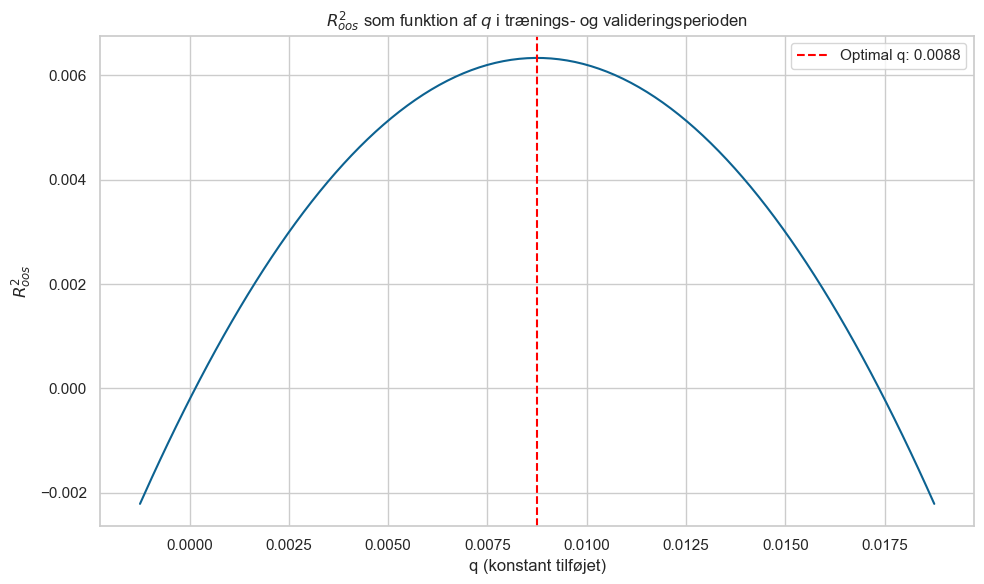

In [66]:
optimal_q, max_r2=optimize_q_r2(df=chars_demean_new, start_dato="2000-12-31", slut_dato="2010-12-31",plot=True)


Optimal faktor q: 0.008752
Maksimeret R²: 0.006334


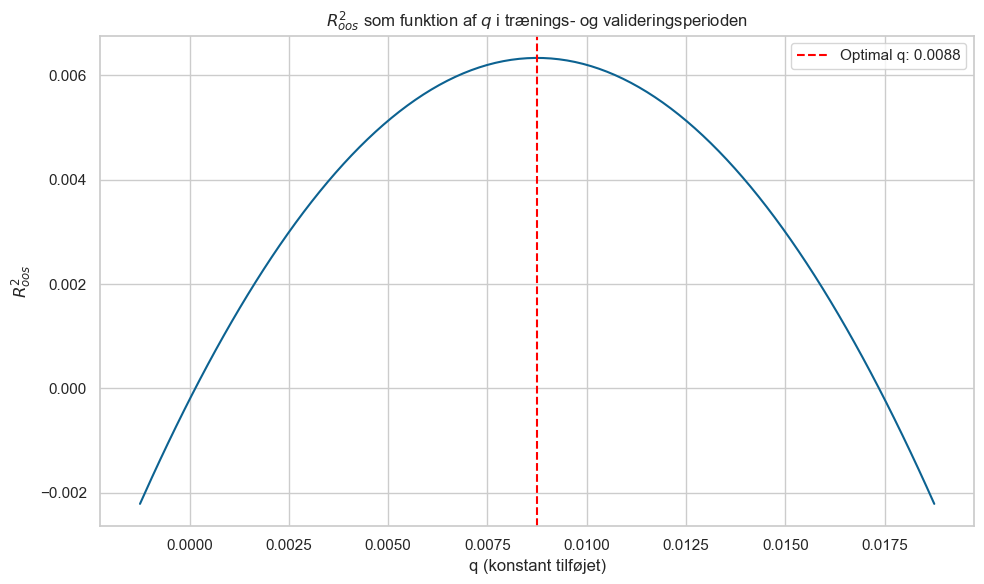

In [22]:
optimal_q, max_r2=optimize_q_r2(df=chars_demean_new, start_dato="2000-12-31", slut_dato="2010-12-31",plot=True)


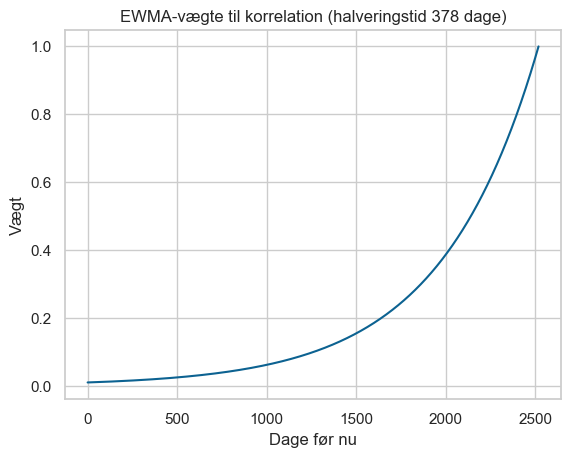

In [72]:
import matplotlib.pyplot as plt

hl_cor = 252 * 3 / 2
obs = 252 * 10
weights = (0.5**(1/hl_cor))**np.arange(obs, 0, -1)
plt.plot(weights)
plt.title("EWMA-vægte til korrelation (halveringstid 378 dage)")
plt.xlabel("Dage før nu")
plt.ylabel("Vægt")
plt.show()


Optimal faktor q: 0.011833
Maksimeret R²: 0.016384


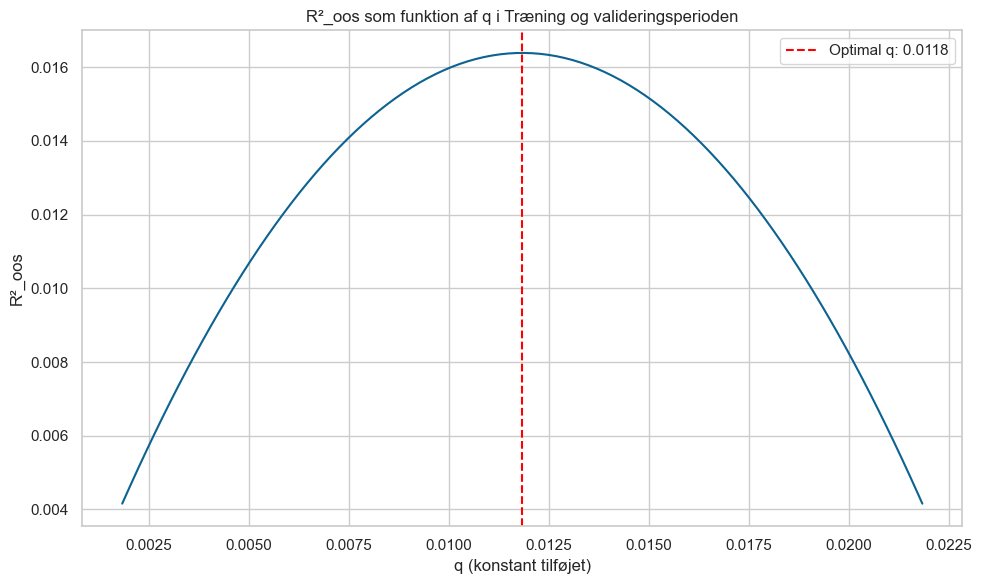

In [16]:
# out of sample
#hars_demean_new["pred_ld1"] = chars_demean_new["pred_ld1"]+optimal_q
optimal_q, max_r2=optimize_q_r2(df=chars_demean_new, start_dato="2010-01-01", slut_dato="2022-12-31",plot=True)

Optimal faktor q: 0.003014
Maksimeret R²: 0.016042


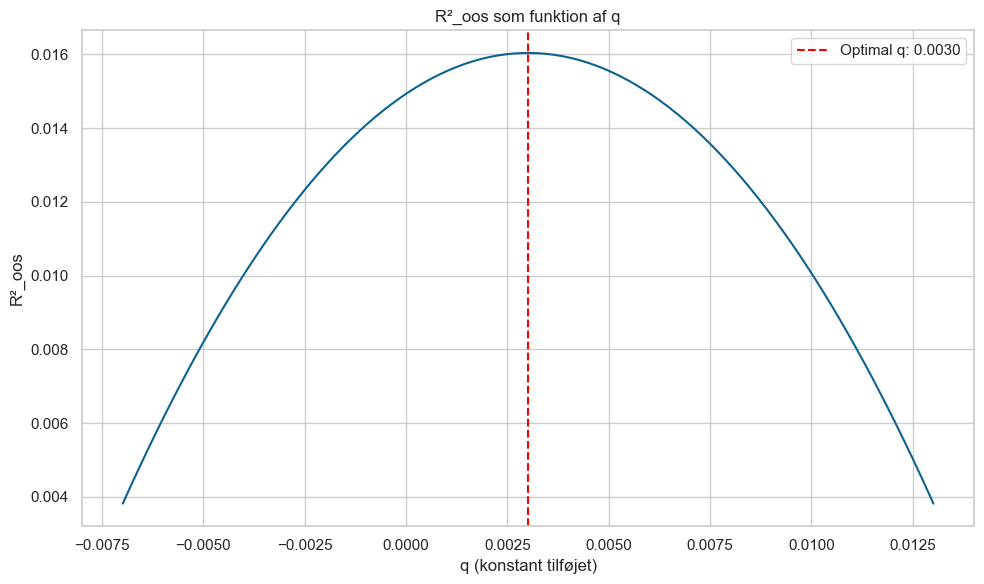

In [151]:
optimal_q, max_r2=optimize_q_r2(df=chars_demean_new, start_dato="2010-01-01", slut_dato="2022-12-31",plot=True)

In [49]:
valgt_dato = "2011-01-01"

chars_arima_test = chars_arima[chars_arima["eom"] > valgt_dato]
chars_arima_test_add = chars_arima_test.copy()
chars_arima_test_add["pred_ld1"] = chars_arima_test_add["pred_ld1"] + optimal_q
chars_arima_r2_test = r2_oos_mean(df = chars_arima_test_add)
print("chars_arima_r2 uden add af mean", chars_arima_r2_test)

In [149]:

chars_demean_new["pred_ld1"] = chars_demean_new["pred_ld1"] + optimal_q

In [45]:
chars_normal_r2_test = r2_oos_mean(df = chars_normal_test)
print(chars_normal_r2_test)

NameError: name 'chars_normal_test' is not defined

In [150]:
chars_normal_r2_test = r2_oos_mean(df = chars_demean_new)
print(chars_normal_r2_test)

(181859, 2)
0.009281807811376441


In [54]:

chars_normal_r2_test = r2_oos_mean(df = chars_normal_test)
chars_arima_r2_test = r2_oos_mean(df = chars_arima_test_add)
#chars_arima_with_mean_r2 = r2_oos(df = chars_arima_with_mean_test)
print("chars_normal_r2 udgangspunkt", chars_normal_r2_test)
print("chars_arima_r2 uden add af mean", chars_arima_r2_test)

(181204, 2)
(101378, 2)
chars_normal_r2 udgangspunkt 0.005910893131711448
chars_arima_r2 uden add af mean 0.012528759194961991


In [152]:
optimal_q

0.003013706748742795

In [121]:
file_path = os.path.join(output_path, f"model_{h}_arima_pred.pkl")
with open(file_path, 'rb') as f:
    model_dict = pickle.load(f)


In [123]:
file_path = os.path.join(output_path, f"model_{h}.pkl")
with open(file_path, 'rb') as f:
    model_dict1 = pickle.load(f)


In [124]:
model_dict1

{datetime.datetime(2000, 12, 31, 0, 0): {'fit': Ridge(alpha=22.90403581082864, fit_intercept=False),
  'pred':            id        eom eom_pred_last      pred
  11      10032 2000-12-31    2001-01-31  0.023582
  12      10032 2001-01-31    2001-02-28  0.006749
  13      10032 2001-02-28    2001-03-31  0.000699
  14      10032 2001-03-31    2001-04-30  0.003390
  15      10032 2001-04-30    2001-05-31  0.008651
  ...       ...        ...           ...       ...
  260737  92655 2001-07-31    2001-08-31  0.011127
  260738  92655 2001-08-31    2001-09-30  0.016845
  260739  92655 2001-09-30    2001-10-31  0.020831
  260740  92655 2001-10-31    2001-11-30  0.023665
  260741  92655 2001-11-30    2001-12-31  0.017784
  
  [8048 rows x 4 columns],
  'hp_search':              g    p        lambda       mse
  0     0.049787    2      0.000000  0.010833
  1     0.049787    2      0.000045  0.010833
  2     0.049787    2      0.000056  0.010833
  3     0.049787    2      0.000068  0.010833
  4   

In [132]:
print(settings['screens']['start'])
print(settings['split']['train_lookback'])
print(settings['split']['val_years'])
print(settings['split']['train_end'])


1982-12-31 00:00:00
100
10
2000-12-31 00:00:00


In [ ]:

# Forbered data
df = mean_ret_ld1_per_eom.copy()
df["eom"] = pd.to_datetime(df["eom"])
df = df.set_index("eom").sort_index()

start_date = pd.to_datetime("2010-12-31")

# === ARIMA ===
train_all = df.loc[:start_date, "ret_ld1"]
order_selection = arma_order_select_ic(train_all, ic='aic', max_ar=3, max_ma=3)
best_order = order_selection['aic_min_order']
print(f"Valgt ARIMA(p,d,q): ({best_order[0]}, 0, {best_order[1]})")

arima_results = []
for current_date in df.loc[:start_date].index[3:]:  # sikre tilstrækkelig lags
    train_data = df.loc[:current_date - pd.offsets.MonthEnd(1), "ret_ld1"]
    try:
        model = ARIMA(train_data, order=(best_order[0], 0, best_order[1]))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1)[0]
    except:
        forecast = None
    arima_results.append({"eom": current_date, "arima_pred": forecast})

arima_df = pd.DataFrame(arima_results).set_index("eom")

# === Naiv model ===
df["naive_pred"] = df["ret_ld1"].shift(1)

# === EWMA ===
df["ewma_pred"] = df["ret_ld1"].ewm(span=6, adjust=False).mean().shift(1)

# === OLS model ===
df["lag1"] = df["ret_ld1"].shift(1)
df["lag2"] = df["ret_ld1"].shift(2)
df["lag3"] = df["ret_ld1"].shift(3)

train = df.loc[:start_date - pd.offsets.MonthEnd(1)].dropna()
test = df.loc[:start_date].dropna()

X_train = train[["lag1", "lag2", "lag3"]]
y_train = train["ret_ld1"]
X_test = test[["lag1", "lag2", "lag3"]]

ols_model = LinearRegression().fit(X_train, y_train)
test["ols_pred"] = ols_model.predict(X_test)

# === Merge alt sammen ===
df = df.join(arima_df)

# === Evalueringsdata: kun før 2010-12-31 ===
eval_df = df.loc[:start_date].dropna()

def r2_oos_mean(df, actual_col, pred_col):
    df_clean = df[[actual_col, pred_col]].dropna()
    rss = ((df_clean[actual_col] - df_clean[pred_col]) ** 2).mean()
    tss = (df_clean[actual_col] ** 2).mean()
    return 1 - rss / tss if tss != 0 else np.nan

r2_scores = {
    "ARIMA": r2_oos_mean(eval_df, "ret_ld1", "arima_pred"),
    "Naiv": r2_oos_mean(eval_df, "ret_ld1", "naive_pred"),
    "EWMA (span=6)": r2_oos_mean(eval_df, "ret_ld1", "ewma_pred"),
    "OLS (lag1-3)": r2_oos_mean(test, "ret_ld1", "ols_pred")
}

# === Udskriv R² sammenligning ===
print("\nR² før 2010-12-31:")
for model, score in r2_scores.items():
    print(f"{model}: {score:.6f}")

# === Plot alle predictions ===
plt.figure(figsize=(14, 6))
plt.plot(eval_df.index, eval_df["ret_ld1"], label="Faktisk mean ret_ld1", color='black')
plt.plot(eval_df.index, eval_df["arima_pred"], label="ARIMA", linestyle="--")
plt.plot(eval_df.index, eval_df["naive_pred"], label="Naiv", linestyle="--")
plt.plot(eval_df.index, eval_df["ewma_pred"], label="EWMA (span=6)", linestyle="--")
plt.plot(test.index, test["ols_pred"], label="OLS (lag1-3)", linestyle="--")
plt.axvline(start_date, color='grey', linestyle=':', label="Evalueringsslut")
plt.title("Sammenligning af modeller på mean ret_ld1 (før 2010)")
plt.xlabel("Dato")
plt.ylabel("Afkast")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
